In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

inputsFilesCount = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        inputsFilesCount+=1

print(f"{inputsFilesCount} files found")

INPUT = "/kaggle/input/smemi309-final-evaluation-challenge-2023"

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

420 files found


In [2]:
!pip install tonic --quiet
!pip install snntorch --quiet

In [3]:
import os
import random

import numpy as np
import pandas as pd
import tonic.datasets.nmnist
import tonic.transforms as transforms
import torch
from torch.utils.data import Dataset


class LipDataset(Dataset):
    dtype = np.dtype([("x", int), ("y", int), ("t", int), ("p", int)])
    sensor_size = (90, 90, 2)

    def __init__(
        self,
        path,
        transform=None,
        target_transform=None,
        transforms=None,
        train=True,
        frames=30,
    ):
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        self.frames = frames

        self.class_labels = {}
        self.files = []
        self.file_labels = []

        self.data_dir = path + ("/train10/train10/" if train else "/test10/test10/")

        for root, dirs, _ in os.walk(self.data_dir):
            for dir in dirs:
                class_name = dir
                class_label = len(self.class_labels)
                self.class_labels[class_name] = class_label

                for file in os.listdir(os.path.join(root, dir)):
                    if file.endswith(".csv"):
                        path = os.path.join(root, dir, file)
                        self.files.append(path)
                        self.file_labels.append(self.class_labels[class_name])

        print("Number of classes found:", len(self.class_labels.values()))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        target = self.file_labels[idx]

        events_input = read_lip_events(self.files[idx])

        if self.transform is not None:
            events_input = self.transform(events_input)
        if self.target_transform is not None:
            events_input = self.target_transform(target)

        return events_input, target


def read_lip_events(path):
    events = np.loadtxt(path, delimiter=",", skiprows=1)
    # swap p and t
    events[:, [2, 3]] = events[:, [3, 2]]

    # keep events where x is between 67 and 157
    events = events[(events[:, 0] > 67) & (events[:, 0] < 157)]
    # subtract 67 from x
    events[:, 0] = events[:, 0] - 67

    events_input = np.fromiter(map(tuple, events), dtype=LipDataset.dtype)
    return events_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Number of classes found: 10
[(54, 71,    2654, 1) (52, 71,    4311, 0) (46, 82,    7077, 1) ...
 ( 4,  0, 2976969, 1) ( 6,  2, 2977531, 0) (83, 41, 2989517, 0)]


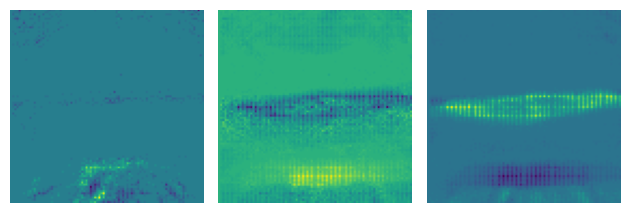

In [4]:
import tonic

dataset = LipDataset(INPUT, train=True)

events, target = dataset[0]
print(events)

tonic.utils.plot_event_grid(events)

In [5]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset
from torch.utils.data import random_split

sensor_size = LipDataset.sensor_size

transform = tonic.transforms.Compose(
    [
        tonic.transforms.RandomCrop(sensor_size=sensor_size, target_size=(80, 80)),
        tonic.transforms.RandomFlipLR(sensor_size=sensor_size),
        tonic.transforms.Denoise(filter_time=10000),
        tonic.transforms.ToFrame(sensor_size=sensor_size, time_window=30000),
    ]
)

dataset = LipDataset(path=INPUT, train=True, transform=transform)
train_set, test_set = random_split(dataset, [256, 64])

cached_trainset = DiskCachedDataset(train_set, cache_path="/kaggle/temp/lip/train")
cached_testset = DiskCachedDataset(test_set, cache_path="/kaggle/temp/lip/test")

batch_size = 32
train_dataloader = DataLoader(
    cached_trainset,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
    shuffle=True,
)
test_dataloader = DataLoader(
    cached_testset,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
)

Number of classes found: 10


In [6]:
print("caching train data")
for i, (datas, targets) in enumerate(train_dataloader):
    print(f"Batch {i+1}/{len(train_dataloader)} : {datas.shape}, {targets.shape}")

print("caching test data")
for i, (datas, targets) in enumerate(test_dataloader):
    print(f"Batch {i+1}/{len(test_dataloader)} : {datas.shape}, {targets.shape}")

caching train data
Batch 1/8 : torch.Size([99, 32, 2, 90, 90]), torch.Size([32])
Batch 2/8 : torch.Size([99, 32, 2, 90, 90]), torch.Size([32])
Batch 3/8 : torch.Size([99, 32, 2, 90, 90]), torch.Size([32])
Batch 4/8 : torch.Size([99, 32, 2, 90, 90]), torch.Size([32])
Batch 5/8 : torch.Size([99, 32, 2, 90, 90]), torch.Size([32])
Batch 6/8 : torch.Size([99, 32, 2, 90, 90]), torch.Size([32])
Batch 7/8 : torch.Size([99, 32, 2, 90, 90]), torch.Size([32])
Batch 8/8 : torch.Size([99, 32, 2, 90, 90]), torch.Size([32])
caching test data
Batch 1/2 : torch.Size([99, 32, 2, 90, 90]), torch.Size([32])
Batch 2/2 : torch.Size([99, 32, 2, 90, 90]), torch.Size([32])


In [7]:
import torch
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

data = train_set.__getitem__(100)[0]

tensor1 = torch.tensor(data[:, 0, :, :])
tensor2 = torch.tensor(data[:, 1, :, :])

In [8]:
fig, ax = plt.subplots()
anim = splt.animator(tensor1, fig, ax)
plt.close()
HTML(anim.to_html5_video())

In [9]:
fig, ax = plt.subplots()
anim = splt.animator(tensor2, fig, ax)
plt.close()
HTML(anim.to_html5_video())

In [10]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch
import torch.nn as nn

device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cpu")
)

In [11]:
# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(
    nn.AvgPool2d(2),  # 80 x 80 => 40 x 40
    nn.Conv2d(2, 8, 5),  # 45 x 45 => 41 x 41
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.AvgPool2d(2),  # 41 x 41 => 20 x 20
    nn.Conv2d(8, 16, 5),  # 20 x 20 => 16 x 16
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.AvgPool2d(2),  # 16 x 16 => 8 x 8
    nn.Flatten(),
    nn.Linear(16 * 8 * 8, dataset.class_labels.__len__()),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True),
).to(device)

print(f"Number of parameters: {sum([p.numel() for p in net.parameters()])}")
print(f"Device used : {device}")

Number of parameters: 13874
Device used : cuda


In [12]:
# this time, we won't return membrane as we don't need it

def forward_pass(net, data):
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net

    for step in range(data.size(0)):  # data.size(0) = number of time steps
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)

    return torch.stack(spk_rec)

In [13]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

num_epochs = 100

train_loss_hist = [] ; test_loss_hist = []
train_acc_hist = [] ; test_acc_hist = []

# training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc = 0

    for i, (data, targets) in enumerate(iter(train_dataloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        acc = SF.accuracy_rate(spk_rec, targets)

        epoch_loss += loss_val.item()
        epoch_acc += acc

    epoch_loss /= len(train_dataloader)
    epoch_acc /= len(train_dataloader)

    if epoch % 5 == 0:
        train_loss_hist.append(epoch_loss)
        train_acc_hist.append(epoch_acc)
        
        with torch.no_grad():
            net.eval()
            test_acc = 0
            
            for i, (data, targets) in enumerate(iter(test_dataloader)):
                data = data.to(device)
                targets = targets.to(device)

                spk_rec = forward_pass(net, data)

                acc = SF.accuracy_rate(spk_rec, targets)
                test_acc += acc
            
            test_acc /= len(test_dataloader)
            test_acc_hist.append(test_acc)

        print(f"Epoch {epoch}")
        print(f"Train Loss: {epoch_loss:.2f}")
        print(f"Train Accuracy: {epoch_acc * 100:.2f}%")
        print(f"Test Accuracy: {test_acc * 100:.2f}%")
        print("")

Epoch 0
Train Loss: 5.89
Train Accuracy: 8.98%
Test Accuracy: 15.62%

Epoch 5
Train Loss: 3.94
Train Accuracy: 17.19%
Test Accuracy: 6.25%

Epoch 10
Train Loss: 3.85
Train Accuracy: 15.23%
Test Accuracy: 10.94%

Epoch 15
Train Loss: 4.06
Train Accuracy: 14.06%
Test Accuracy: 3.12%

Epoch 20
Train Loss: 3.74
Train Accuracy: 24.22%
Test Accuracy: 9.38%

Epoch 25
Train Loss: 3.50
Train Accuracy: 19.14%
Test Accuracy: 15.62%

Epoch 30
Train Loss: 3.18
Train Accuracy: 30.47%
Test Accuracy: 15.62%

Epoch 35
Train Loss: 3.03
Train Accuracy: 41.02%
Test Accuracy: 15.62%

Epoch 40
Train Loss: 3.60
Train Accuracy: 36.33%
Test Accuracy: 14.06%

Epoch 45
Train Loss: 3.04
Train Accuracy: 37.89%
Test Accuracy: 25.00%

Epoch 50
Train Loss: 3.09
Train Accuracy: 33.59%
Test Accuracy: 15.62%

Epoch 55
Train Loss: 2.75
Train Accuracy: 49.61%
Test Accuracy: 15.62%

Epoch 60
Train Loss: 3.03
Train Accuracy: 41.41%
Test Accuracy: 23.44%

Epoch 65
Train Loss: 2.45
Train Accuracy: 61.72%
Test Accuracy: 18.75%

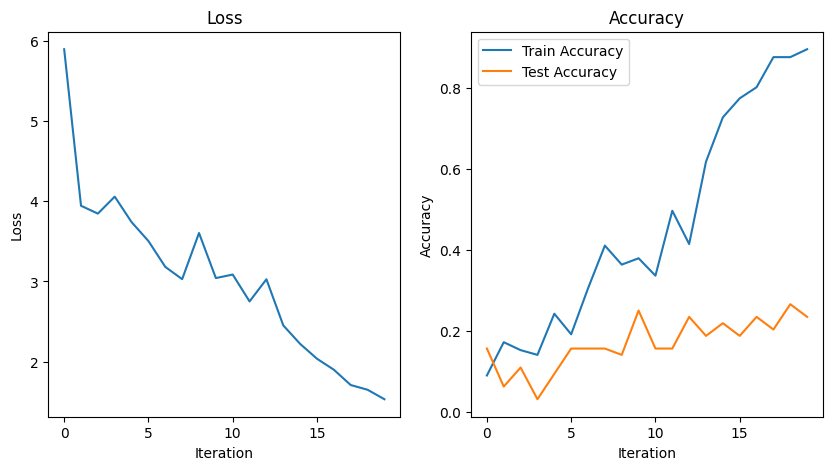

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_loss_hist)
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(122)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Test Accuracy")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

plt.show()

In [15]:
with torch.no_grad():
    net.eval()
    test_acc = []
    
    for i, (data, targets) in enumerate(iter(test_dataloader)):
        data = data.to(device)
        targets = targets.to(device)

        spk_rec = forward_pass(net, data)

        acc = SF.accuracy_rate(spk_rec, targets)
        test_acc.append(acc)

        print(f"It {i} Accuracy: {acc * 100:.2f}%")

    print(f"Test Accuracy: {sum(test_acc) / len(test_acc) * 100:.2f}%")

It 0 Accuracy: 28.12%
It 1 Accuracy: 25.00%
Test Accuracy: 26.56%


In [16]:
# classify data
import os
import pandas as pd
from tqdm.notebook import tqdm

net.eval()

def prediction(path, transformer):
    with torch.no_grad():
        events = read_lip_events(path)
        events = transformer(events)
        datas = torch.tensor(events).to(device).unsqueeze(1).float()

        output = forward_pass(net, datas)
        spikes = output.sum(dim=0).cpu().numpy()
        pred = np.argmax(spikes)
        return pred

transform = tonic.transforms.Compose(
    [
        tonic.transforms.CenterCrop(sensor_size=sensor_size, size=(80, 80)),
        tonic.transforms.Denoise(filter_time=10000),
        tonic.transforms.ToFrame(sensor_size=sensor_size, time_window=30000),
    ]
)

pred_dir = INPUT + "/test10/test10"

df = pd.DataFrame(columns=["Id", "Label"])
for file in tqdm(os.listdir(pred_dir)):
    if file.endswith(".csv"):
        pred = prediction(os.path.join(pred_dir, file), transform)
        class_name = list(dataset.class_labels.keys())[pred]

        df.loc[len(df)] = [file[:-4], class_name]

df.sort_values(by="Id", inplace=True)
df.to_csv("/kaggle/working/results.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
df = pd.read_csv("/kaggle/working/results.csv")
df.sort_values(by="Id", inplace=True)
df.to_csv("results.csv", index=False)
df.head()

,Id,Label
0,0,Addition
1,1,Ecole
12,2,Ecole
23,3,Addition
34,4,Ruisseau
